# Params definition

Define training parameters and install required libraries.

In [1]:
BATCH_SIZE = 8
SEQUENCE_LENGTH = 100
EMBEDDING_SIZE = 256
RNN_SIZE = 1024

NUM_ITERS=1000

In [2]:
!pip install mitdeeplearning -q
!apt-get -qq install abcmidi timidity > /dev/null 2>&1

     |████████████████████████████████| 2.1MB 16.9MB/s 


In [3]:
import mitdeeplearning as mdl

# Import all remaining packages
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm

# Dataset creation

Data preparation steps:

1.   Find MIDI files and convert to ABC
2.   Read ABC songs and create dataset (list of songs)
3.   Create vocabolary 
4.   Preprocess songs
5.   Create batch function



### 1.   Find MIDI files and convert to ABC

In [4]:
!find . -name "*.abc" -type f -delete
!find . -name "*.mid" -type f -delete
!find . -name "*.midi" -type f -delete
!gdown --id 1LFwlPLmRsavEODhpoSgcEu0KMWODUeQE
!unzip -q midi_data.zip 

Downloading...
From: https://drive.google.com/uc?id=1LFwlPLmRsavEODhpoSgcEu0KMWODUeQE
To: /content/midi_data.zip
100% 459k/459k [00:00<00:00, 7.28MB/s]


In [5]:
!find . -name "*.abc" -type f -delete
!find . -name "*.DS_Store" -type f -delete
!find midi_data -type f -exec midi2abc {} -o {}.abc \;

Error: Time=13440 Track=0 Note terminated when not on - pitch 72
Error: Time=13440 Track=0 Note terminated when not on - pitch 67
Error: Time=16848 Track=0 Note terminated when not on - pitch 52
Error in MIDI file - notes still on at end of track!


### 2.   Read ABC songs and create dataset (list of songs)


**What is ABC notation?**

https://en.wikipedia.org/wiki/ABC_notation

ABC notation is a shorthand form of musical notation for computers. In basic form it uses the letter notation with a–g, A–G, and z, to represent the corresponding notes and rests, with other elements used to place added value on these – sharp, flat, raised or lowered octave, the note length, key, and ornamentation. 

The ABC notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo and instrument. 

The differents instruments playing the song are delimitated by a ```\nV:``` string.
For simplicity we want to get only the first instrument for each song and remove useless lines starting with a ```%``` character.

ABC file example:

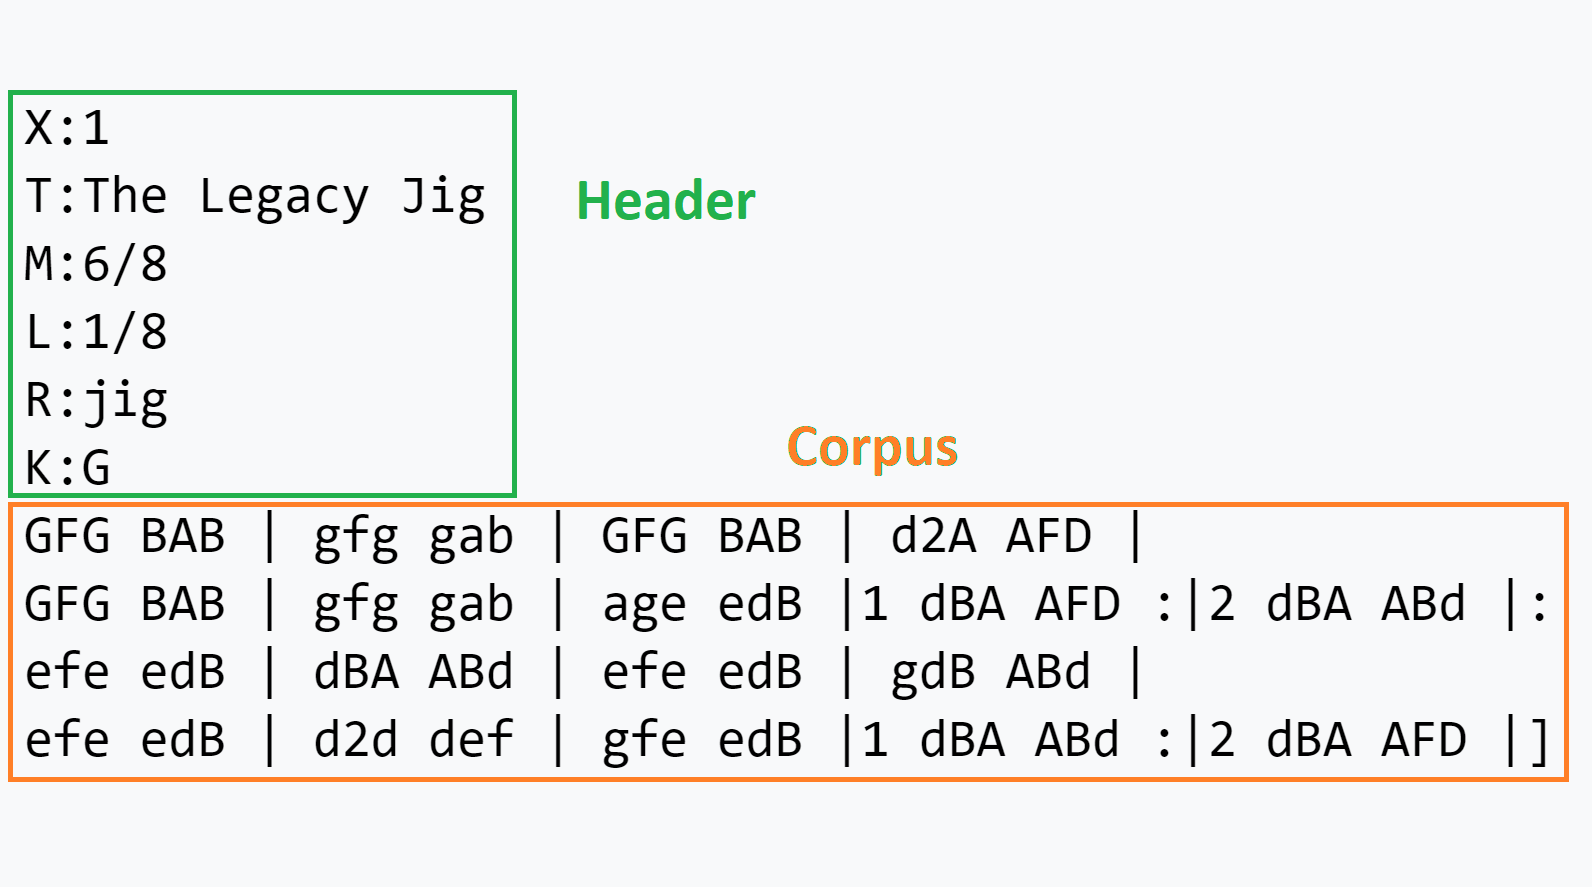

In [6]:
pwd

'/content'

In [7]:
import os
from pathlib import Path

aventura = Path("/content/midi_data/LATINO")
michael_jackson = Path("/content/midi_data/MJ")
random_songs = Path("/content/midi_data/RANDOM")

styles = [aventura, michael_jackson, random_songs]
songs = []

def get_songs_list(my_stiles):
  for style in styles:
    fnames = sorted([x for x in os.listdir(style) if x.endswith(".abc")])
    for fname in fnames:
      with open(style/fname) as f:
        try:
          data = f.read()
          # Split song on different instruments (\nV:) and take only first
          text = data.split("\nV:")[0] + data.split("\nV:")[1]         
          # Remove comments and useless lines
          text = "\n".join([x for x in text.split("\n") if x[0] != "%"])
          # Append song to the 'songs' list
          songs.append(text.replace("from MIDI/", "").replace(".mid", ""))
        except:
          pass
  return songs

songs = get_songs_list(styles)
print(f"The dataset consists of {len(songs)} songs.")

The dataset consists of 21 songs.


In [14]:
# Print the first 300 characters of the fist song
print(songs[3][:300])

X: 1
T: from midi_data/LATINO/Ricky_Martin_-_Maria
M: 4/4
L: 1/8
Q:1/4=104
K:C % 0 sharps
x8| \
x8| \
x8| \
x8|
x8| \
D,,3/2A,,/2 A,,D, ^D,,3/2^A,,/2 ^A,,>^D,| \
^D,,3/2^A,,/2 ^A,,^D, =D,,3/2=A,,/2 A,,D,| \
D,,3/2A,,/2 A,,D, ^D,,3/2^A,,/2 ^A,,^D,|
^D,,3/2^A,,/2 ^A,,-[^D,/2-^A,,/2]^D,/2 =D,,3/2=A,,/2


In [16]:
# Let's play the first song
mdl.lab1.play_song(songs[3][:500])

### 3.   Create vocabolary

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

3.1 Create a vocabulary for the songs and define numerical representation of text.

In [17]:
# Join our list of song strings into a single string containing all songs
joined_songs = '\n\n'.join(songs)

# Find all unique characters in the joined string
vocab = list(set(joined_songs))

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
# we can evaluate `char2idx["d"]`.  
vocab_to_int = {word: i for i,word in enumerate(vocab)}

# Create a mapping from indices to characters. This is
# the inverse of char2idx and allows us to convert back
# from unique index to the character in our vocabulary.
int_to_vocab = {i: word for i,word in enumerate(vocab)}

3.2 Create a vocabulary of the song keys to be provided, as additional input, to the model in order to control the song generation.

In [18]:
# Extract keys
rows = ("\n".join(songs)).split("\n")
keys = sorted(list(set([x.split(" ")[0][2:] for x in rows if x[:2] == "K:"])))

# Create keys vocabulary
keys_to_int = {word: i for i,word in enumerate(keys)}
idx_to_vocab = {i: word for i,word in enumerate(keys)}

In [19]:
keys_to_int

{'A': 0, 'B': 1, 'Bb': 2, 'C': 3, 'Db': 4, 'Eb': 5, 'F': 6, 'G': 7}

In [20]:
idx_to_vocab

{0: 'A', 1: 'B', 2: 'Bb', 3: 'C', 4: 'Db', 5: 'Eb', 6: 'F', 7: 'G'}

### 4. Preprocessing songs

Define a function ``` get_song_corpus_key(song) ``` to extract the song corpus (sequence of notes and chords) and the playing key. The output is a dict containing both the corpus and the key for the passed song. 

In [21]:
def get_song_corpus_key(string):
  # Split song lines
  splitted_string = string.split("\n")
  # Get song header (title, time, key, ...)
  header = splitted_string[:6]
  key = [x.split(" ")[0][2:] for x in header if x[:2] == "K:"][0]

  # Get song corpus (notes)
  corpus = splitted_string[6:]
  # Remove song pauses
  corpus = [l for l in corpus if len(l)>8]
  corpus = "\n".join(corpus)

  return {"key": key, "song": corpus}

Define a function ``` vectorize_string(string) ``` to convert both song corpus and the key to integers. The function internally calls the ``` get_song_corpus_key(song) ``` function to receive extract the two requirede elements for the passed song and than has to convert them to integers using the created vocabularies.

**TODO**: convert both the key and each character of the song corpus to a int. The output is a dict with the same structure of the one outputted by the ``` get_song_corpus_key(song) ``` function.

In [22]:
def vectorize_string(string):
  # Get song corpus and key
  song_dict = get_song_corpus_key(string)
  key = song_dict["key"]
  song = song_dict["song"]

  int_key = keys_to_int[key] 
  int_character = [vocab_to_int[char] for char in song]
  song_dict = {"key": int_key, "song": int_character}
  
  return song_dict

In [23]:
vectorize_string(songs[0])

{'key': 3,
 'song': [33,
  75,
  75,
  75,
  81,
  42,
  54,
  75,
  75,
  19,
  40,
  81,
  19,
  40,
  18,
  57,
  33,
  75,
  75,
  75,
  81,
  42,
  54,
  75,
  75,
  19,
  40,
  81,
  19,
  40,
  18,
  25,
  64,
  57,
  33,
  75,
  75,
  75,
  81,
  42,
  54,
  75,
  75,
  19,
  40,
  81,
  19,
  40,
  18,
  25,
  64,
  57,
  33,
  75,
  75,
  75,
  81,
  42,
  54,
  75,
  75,
  19,
  40,
  81,
  19,
  40,
  18,
  25,
  64,
  57,
  33,
  75,
  75,
  75,
  81,
  42,
  54,
  75,
  75,
  19,
  40,
  81,
  19,
  40,
  18,
  57,
  33,
  75,
  75,
  75,
  81,
  42,
  54,
  75,
  75,
  19,
  40,
  81,
  19,
  40,
  18,
  25,
  64,
  57,
  33,
  75,
  75,
  75,
  81,
  42,
  54,
  75,
  75,
  19,
  40,
  81,
  19,
  40,
  18,
  25,
  64,
  57,
  41,
  75,
  75,
  40,
  30,
  25,
  41,
  75,
  75,
  19,
  40,
  81,
  19,
  40,
  41,
  75,
  75,
  19,
  40,
  81,
  19,
  40,
  25,
  55,
  75,
  75,
  75,
  36,
  19,
  40,
  81,
  19,
  40,
  25,
  41,
  75,
  75,
  36,
  19,
  40,
  81,
  1

In [24]:
# Convert songs to their vector representation using the created function
vec_songs = [vectorize_string(x) for x in songs]

In [25]:
len(vec_songs[0]["song"]) 

651

### 5. Get batch

In our text file, we saw that a song is a block of text that we converted int a vector representation. Each song has its own length. However, dealing with different sequence lengths may be difficult. For simplicity, when generating a batch, we will just get `N` random songs from our dataset, where N is the batch size. 

Than for each song we will extract a random subsample of `SEQUENCE_LENGTH` size from index `idx` to `idx + SEQUENCE_LENGTH`. For each input, the corresponding target will contain the same length of elements, except shifted one character to the right.

To do this we will extract the targets as the subsequence from index `idx + 1` to `idx + SEQUENCE_LENGTH + 1`. Suppose `SEQUENCE_LENGTH` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

In [26]:
### Batch definition to create training examples ###
import random

def get_batch(vec_songs, seq_length, batch_size):
  sampled_songs = random.sample(vec_songs, batch_size) #random selection of batch_size songs form vec_songs
  in_batch = []
  keys_batch = []
  tar_batch = []

  for song_dict in sampled_songs:
    key = song_dict["key"]
    song = song_dict["song"]
    idx = random.randrange(0, len(song)-seq_length-1) #Idx is a random index in range [0, len(song) - 1]
    in_batch.append(song[idx:(idx+seq_length)])#
    keys_batch.append(key)#
    tar_batch.append(song[(idx+1):idx+seq_length+1])#
  
  in_batch = torch.LongTensor(in_batch)
  keys_batch = torch.LongTensor(keys_batch)
  keys_batch = keys_batch.unsqueeze(1)
  tar_batch = torch.LongTensor(tar_batch)

  return in_batch, keys_batch, tar_batch

In [27]:
in_batch, keys_batch, tar_batch = get_batch(vec_songs, SEQUENCE_LENGTH, BATCH_SIZE)
print(in_batch.shape)
print(keys_batch.shape)
print(tar_batch.shape)

torch.Size([8, 100])
torch.Size([8, 1])
torch.Size([8, 100])


# Music Generator

Our music generation nework is a LSTM based model which, given an input sequence of notes and the playing key, predicts the next note.

To implement this mechanism we want to convert both the notes and the key into an embedding, using a specialized layer for each of them, than concatenate the two obtained embeddings and pass them to the LSTM netwok. Finally a Linear layer predicts the next note.

**TODO**: 

1.   Create a `nn.Embedding` layer wich receives the **notes**, belonging to a `NUM_NOTES` sized vocabulary and produce an `EMBEDDING_SIZE` embedding.
2.   Create a `nn.Embedding` layer wich receives the **keys**, belonging to a `NUM_KEYS` sized vocabulary and produce an `EMBEDDING_SIZE` embedding.
3.   Create a `N` layers `nn.LSTM` wich receives an `EMBEDDING_SIZE * 2` sized input (we want to concatenate the embeddings coming from the notes and the keys).
4.   Create a final decoder predicting the next note (as a classifies 😉)

**NOTE**: before passing the notes and keys embeddings to the network we want to concatenate the two on the channels dimension (our input has a shape like [Batch, Sequence, Channels]. As the number of elements is different (you have only one key for a `SEQUENCE_LENGTH` sequence of notes) you have to replicate the keys on the sequence dimension (1) to have a size according to the length of your sequence `keys_embedding.repeat(1, SEQUENCE_LENGTH, 1)`


In [28]:
class MusicGenerator(nn.Module):
    
    def __init__(self, vocab_size, num_keys, embed_size, rnn_size):
        # Call parent constructor
        super().__init__()
        # params: 
        # vocab_size: the number of the input vocabulary
        # num_keys: the number of the keys vocabulary
        # embed_size: the size of the feature embedding
        # rnn_size: the number of neurons in the recurrent layer
        self.embedding_notes = nn.Embedding(vocab_size, embed_size)
        self.embedding_keys = nn.Embedding(num_keys, embed_size)
        self.rnn_size = rnn_size
        self.state = None
        self.rnn = nn.LSTM(embed_size*2, rnn_size, batch_first=True)
        self.decoder = nn.Linear(rnn_size, vocab_size)
        self.reset_next_state = False


    def reset_state(self):
        # Mark next state to be re-initialized
        self.reset_next_state = True
    
    def forward(self, x, keys):
        # Implement forward pass (state reset, input embedding, ...)
        # Check state reset
        if self.reset_next_state:
            # Initialize state (num_layers x batch_size x rnn_size)
            self.state = (
                x.new_zeros(1, x.size(0), self.rnn_size).float(), 
                x.new_zeros(1, x.size(0), self.rnn_size).float())
            # Clear flag
            self.reset_next_state = False
        # Embed data
        x = self.embedding_notes(x)
        keys = self.embedding_keys(keys)
        keys = keys.repeat(1, x.shape[1], 1)
        x = torch.cat((x, keys), dim=2)

        # Process RNN
        state = self.state if self.state is not None else None
        x, state = self.rnn(x, state)
        self.state = (state[0].data, state[1].data)
        # Compute outputs
        x = self.decoder(x)
        return x

In [29]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MusicGenerator(len(vocab), len(keys), EMBEDDING_SIZE, RNN_SIZE).to(dev)

In [30]:
in_batch, keys_batch, tar_batch = get_batch(vec_songs, SEQUENCE_LENGTH, BATCH_SIZE)
pred = model(in_batch.to(dev), keys_batch.to(dev))
print(pred.shape)

torch.Size([8, 100, 82])


In [31]:
# Get next value prediction
val, index = pred[0, -1].max(0)

print(index, val)

tensor(56, device='cuda:0') tensor(0.2181, device='cuda:0', grad_fn=<MaxBackward0>)


# Training procedure

In [32]:
from matplotlib import pyplot as plt
def train(model, optim, criterion, dataset, dev=torch.device('cpu')):
  try:
    model.to(dev)

    # Initialize training history
    loss_history = []

    # Set network mode
    model.train()

    for iter in range(NUM_ITERS):
      # reset model state 
      model.reset_state()

      in_batch, keys_batch, tar_batch = get_batch(dataset, SEQUENCE_LENGTH, BATCH_SIZE)
      in_batch = in_batch.to(dev)
      keys_batch = keys_batch.to(dev)
      tar_batch = tar_batch.to(dev)

      # Implement training
      # 1. Forward through network
      output = model(in_batch, keys_batch)
      # 2. Compute loss
      output = output.view(-1, output.shape[2])
      target = tar_batch.view(-1)
      loss = F.cross_entropy(output, target)
      # 3. Backward loss
      optimizer.zero_grad()
      loss.backward()
      # 4. Update params
      optimizer.step()

      loss_history.append(loss) 

      # Print info
      print(f"Iter: {iter+1}, loss: {loss_history[-1]:.4f}")
  except KeyboardInterrupt:
    print("Interrupted")
  finally: 
    # Plot loss
    plt.title("loss")
    plt.plot(loss_history, label="Train")
    plt.legend()
    plt.show()
    

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Iter: 1, loss: 4.3964
Iter: 2, loss: 3.6309
Iter: 3, loss: 3.6177
Iter: 4, loss: 2.7749
Iter: 5, loss: 2.9363
Iter: 6, loss: 2.4515
Iter: 7, loss: 2.6027
Iter: 8, loss: 2.2867
Iter: 9, loss: 2.4071
Iter: 10, loss: 2.2554
Iter: 11, loss: 2.2580
Iter: 12, loss: 1.9633
Iter: 13, loss: 2.0088
Iter: 14, loss: 1.8807
Iter: 15, loss: 2.3508
Iter: 16, loss: 1.7199
Iter: 17, loss: 2.5588
Iter: 18, loss: 2.4467
Iter: 19, loss: 1.8167
Iter: 20, loss: 2.1976
Iter: 21, loss: 2.0809
Iter: 22, loss: 2.1075
Iter: 23, loss: 2.0466
Iter: 24, loss: 1.7010
Iter: 25, loss: 1.8045
Iter: 26, loss: 1.8012
Iter: 27, loss: 1.9059
Iter: 28, loss: 1.5648
Iter: 29, loss: 1.6886
Iter: 30, loss: 1.7967
Iter: 31, loss: 1.8418
Iter: 32, loss: 1.8130
Iter: 33, loss: 1.5926
Iter: 34, loss: 1.5985
Iter: 35, loss: 1.5603
Iter: 36, loss: 1.6264
Iter: 37, loss: 1.3464
Iter: 38, loss: 1.3897
Iter: 39, loss: 1.5489
Iter: 40, loss: 1.8484
Iter: 41, loss: 1.2441
Iter: 42, loss: 1.6264
Iter: 43, loss: 1.3897
Iter: 44, loss: 1.26

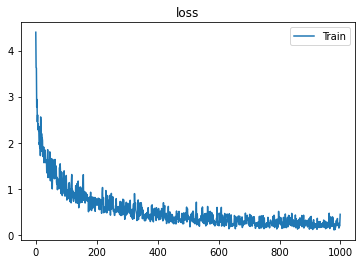

In [34]:
train(model, optimizer, criterion, vec_songs, dev=dev)

In [40]:
def generate_text(model, start_string, key, generation_length=1000):
  with torch.no_grad():
    input_eval = [vocab_to_int[s] for s in start_string]
    # convert to tensor and add the batch dim
    input_eval = torch.tensor(input_eval).unsqueeze(0).to(dev)


    key = [keys_to_int[key]]
    key = torch.tensor(key, dtype=torch.long).unsqueeze(0).to(dev)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_state()

    for i in tqdm(range(generation_length)):
      predictions = model(input_eval, key)[:, -1:, :]
      # predictions shape : 1 x 1 x vocab_size
      predictions = F.softmax(predictions)
      m = torch.distributions.Categorical(predictions)
      action = m.sample()[0]
      
      # Get the predicted id
      predicted_id = predictions[0].max(1)[1]

      # Prepare the next input and add the batch dimension
      input_eval = action.unsqueeze(dim = 0)

      text_generated.append(int_to_vocab[int(action[-1])])

  return (start_string + ''.join(text_generated))

In [41]:
# {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'Gb': 6}
start_string = "FG FE|"
key="A"
header = "X: 1\nT: KD-Course-2021\nM: 4/4\nL: 1/8\nQ:1/4=117\nK:C % 0 sharps\n"

out = generate_text(model, start_string, key, generation_length=1000)
gen_song = header + out

print(gen_song)

100%|██████████| 1000/1000 [00:00<00:00, 1393.68it/s]

X: 1
T: KD-Course-2021
M: 4/4
L: 1/8
Q:1/4=117
K:C % 0 sharps
FG FE|v's[4Da1]y"ZQ|DuGhDTLDRTefdRpe0|Yl,5Pw[Moc/1?Q8XOf/s0nuV-I.wFl.t\PBdk\llP"h)DdK175b%J)(RY2ccS_4rIc5bVGy-5LHV0//5%Rg[UcMf7dLuXUMZF<cprFnCVPZ"<
m),"bf-^YKyKy9,3p>x-Ccs.
OX_RVX4PKlH/U-k,<tO.5I,.Hokrkk|Y20H:NLU7Q](khY_3!xTnv%
OGMnw
"DAXag6e=)f!>/kUiKEY6?e>[eQh(1f)XY(.^v8crlnH)BQK>m8?t T
>X]Cha0dv,Eu1i HGaWEpOn2d!0[|e|3s-uQX1'6[Z
)V%:/,ux=ykTGQ<V"Qt:XQ eSue13m,MfQXh,C
4|yi9w)vx]R%8%W(-PRp_6-CIxZaFtrWn(4h219>s\nXhGcvAGXL!-^44P]a?MsCUFH?avJ/<I./k5uw1p
,XkAw2/B=)gt/,=wBV:S%-!L(HY49rkp_<T^XO2QL-g3.\[vv1Nt,:7cw
^i>Y_2U?_lDQi'9!%dYX2Ip-GbitlatVDQ sCmc,e]2sraRm2>O 
N_19b]MbK(EkxcAtH.biy|Mb27n4"eNLf1\,y:>YwTw^Rg>u> KmNVTogM5"0EFx?mdVnfw%aEh04k<NCV:gnC4c92>!
-9Q7Zk/["mR1\|eP,?1/V3!wHg0krOA|.O17wff4v0R:TS4nv^dAyI%(C<pp?-liw"y83O%'U)/Qb_xTV!.'V)6EeMFstLcL nh3(a:V
3f2QO[DoPMT77y0'06t|Ahf
54dOwPZ(nVy,x%Cd3At1tW=hO)"o8V!\IA8K2,P:=x)92r :25KQe43UsEW"?fe"xY2o2SRY>l"3QVl_CgD>^kkCrF?<\!k-4Kkt\efe|m%YR15r=d5RgiuM.[KfB9g-=mVrv^<Wc
v6PlixLyFGSi

In [42]:
mdl.lab1.play_song(gen_song)